In [1]:
import imageio
import os
import pydot
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
def preprocess_imagery(path):
    '''
    Pre process satellite imagery. We check for nans in the composite images,
    and then we load them into the [0,1] range.
    Input: TIF files downloaded from GEE (224x224x7)
    '''
    # Reading image
    path = str(path).strip('b').strip("'")
    path="C:/Users/benja/Desktop/tesis/GEE_Images/"+path+".tif"
    image = (imageio.imread(path))
    """if np.sum(np.isnan(image)) > 0:
        # Taking the mean of the image, per channel
        mean = np.nanmean(image, axis=(0, 1))
        # Replacing NaN with per channel mean
        replacement = np.isnan(image) * mean
        image[np.isnan(image)] = replacement[np.isnan(image)]  
        nan_channels = np.all(np.isnan(image), axis=(0, 1))
        # Replacing NaN with 0 where all values in a channel are NaN
        image[:, :, nan_channels] = np.nan_to_num(image[:, :, nan_channels])
    # Scale the image to [0, 1] range
    image = image / 255"""
    return image

In [3]:
image_files = [f for f in os.listdir("../GEE_Images")]
image_info = []
df = pd.read_csv('processed_data.csv')

for image in image_files:
    name, _ = os.path.splitext(image)
    # Extraer estación y fecha de las imágenes
    station = '_'.join(name.split(' ')[0].split('_')[:-1])
    date = name.split(' ')[0].split('_')[-1]
    image_info.append([station, date,name])

# Añadimos una columna para asociar imágenes en df
df['image'] = None  # Inicialmente sin imágenes asociadas

# Ahora asociamos cada imagen a su registro en df
for info in image_info:
    df.loc[(df['station'] == info[0]) & (df['Date'] == info[1]), 'image'] = info[2]

# Verificar que las imágenes se han asignado correctamente
print(df.head())


      mp10    station    mp2.5  dirviento  tamb  so2  velviento     hrel  \
0  178.542  El_bosque  49.7829    221.195   NaN  9.5   0.950428  40.5833   
1  178.542  El_bosque  49.7829    221.195   NaN  9.5   0.950428  40.5833   
2  178.542  El_bosque  49.7829    221.195   NaN  9.5   0.950428  40.5833   
3  178.542  El_bosque  49.7829    221.195   NaN  9.5   0.950428  40.5833   
4  146.042  El_bosque  49.7829    221.195   NaN  9.5   0.950428  40.5833   

       no2       o3  ...       no        co  region        Date  Year  Month  \
0  30.3333  16.9167  ...  34.8333  0.929165       1  1997-04-02  1997      4   
1  30.3333  12.4583  ...  34.8333  0.929165       1  1997-04-03  1997      4   
2  30.3333  23.2083  ...  34.8333  0.929165       1  1997-04-04  1997      4   
3  30.3333  28.2917  ...  34.8333  0.929165       1  1997-04-05  1997      4   
4  30.3333  21.2083  ...  34.8333  1.204160       1  1997-04-06  1997      4   

   Day        lat       long  image  
0    2 -33.547016 -70.66

In [10]:
df['image'].describe()

count                             51782
unique                            51782
top       El_bosque_1997-07-01 00_00_00
freq                                  1
Name: image, dtype: object

In [4]:
df_Scaled=df.copy()
# Crear un diccionario para almacenar los datos de cada locación
df_Scaled.fillna(value=0,inplace=True)
grouped_data = {location: location_df.sort_values(by='Date') for location, location_df in df_Scaled.groupby('station')}

In [5]:
grouped_data['talagante']['image']

146624                                0
146625                                0
146626                                0
146627                                0
146628                                0
                      ...              
151912                                0
151913                                0
151914                                0
151915                                0
151916    talagante_2024-04-22 00_00_00
Name: image, Length: 5293, dtype: object

In [13]:
import numpy as np
import pandas as pd

# Obtener la serie de fechas e imágenes
date_series = grouped_data['talagante']['Date'].values  # Asegúrate de tener una columna 'Date' en el dataset
image_series = grouped_data['talagante']['image'].values

# Convertir las fechas a formato datetime
date_series = pd.to_datetime(date_series)

# Crear una lista para almacenar las diferencias de días entre imágenes
day_differences = []

# Guardar la fecha de la última imagen válida
last_image_date = None

# Recorrer todas las fechas e imágenes
for date, image in zip(date_series, image_series):
    if image!=0:  # Si hay una imagen válida
        if last_image_date is not None:
            # Calcular la diferencia de días con la última imagen válida
            days_between = (date - last_image_date).days
            day_differences.append(days_between)
        
        # Actualizar la última fecha con imagen válida
        last_image_date = date

# Calcular el promedio de días entre imágenes
if day_differences:
    avg_days_between_images = np.mean(day_differences)
    print(f"El promedio de días entre imágenes es: {avg_days_between_images:.2f}")
    avg_days_between_images = np.max(day_differences)
    print(f"El máximo de días entre imágenes es: {avg_days_between_images:.2f}")
    avg_days_between_images = np.min(day_differences)
    print(f"El mínimo de días entre imágenes es: {avg_days_between_images:.2f}")
    avg_days_between_images = np.std(day_differences)
    print(f"La desviación estándar imágenes es: {avg_days_between_images:.2f}")
else:
    print("No se encontraron suficientes imágenes para calcular la diferencia.")


El promedio de días entre imágenes es: 3.73
El máximo de días entre imágenes es: 494.00
El mínimo de días entre imágenes es: 1.00
La desviación estándar imágenes es: 13.48


<Axes: ylabel='Count'>

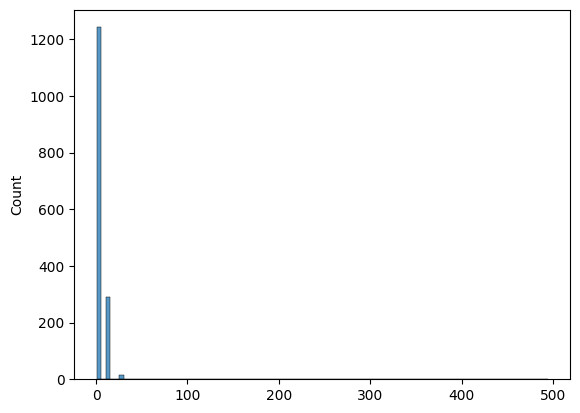

In [14]:
import seaborn as sns
sns.histplot(day_differences,bins=100)

In [76]:
import pandas as pd

# Definir el número de días en cada secuencia (sequence_length)
sequence_length = 10  # o el valor que estés usando para la LSTM

# Obtener la serie de imágenes
image_series = grouped_data['talagante']['image'].values

# Variables para contar secuencias con y sin imagen
sequences_with_image = 0
sequences_without_image = 0

# Recorrer los datos de 'image' en bloques de sequence_length
for i in range(sequence_length, len(image_series)):
    # Seleccionar la secuencia de `sequence_length` días
    image_associated = image_series[i-sequence_length:i]
    
    # Buscar una imagen en la secuencia (la más cercana al último día)
    image_file = next((img for img in reversed(image_associated) if img!=0), None)
    
    if image_file:
        sequences_with_image += 1  # Secuencia tiene una imagen válida
    else:
        sequences_without_image += 1  # Secuencia no tiene imagen

# Imprimir los resultados
print(f"Secuencias con imagen: {sequences_with_image}")
print(f"Secuencias sin imagen: {sequences_without_image}")


Secuencias con imagen: 4360
Secuencias sin imagen: 923


### Usando 7 días previos para predecir el día siguiente (Sin capping)

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = target[i]
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (103015, 7, 17), Forma de y: (103015, 1), Total de imágenes: (103015,)
Train set: X=(72110, 7, 17), y=(72110, 1), images=(72110,)
Test set: X=(20706, 7, 17), y=(20706, 1), images=(20706,)
Validation set: X=(10199, 7, 17), y=(10199, 1), images=(10199,)


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import LSTM, Concatenate
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dropout
import tensorflow as tf

# Definir la métrica personalizada SMAPE
def smape(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()  # Pequeño valor para evitar divisiones por cero
    denominator = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0 + epsilon
    diff = tf.abs(y_true - y_pred) / denominator
    return 100.0 * tf.reduce_mean(diff)  # Se devuelve el error en porcentaje


# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        880 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 26, 26,    │          0 │ conv2d_2[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 12, 12,    │          0 │ conv2d_3[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    589,952 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 7, 50)     │     13,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50)        │     20,200 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 178)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     22,912 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
import tensorflow as tf

# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [27]:
from tensorflow.keras.callbacks import EarlyStopping

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=10,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)


In [20]:
X_train[0].shape

(7, 17)

In [22]:
checkpoint_path = "training_1/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [30]:
import pickle
history=model.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)




Epoch 1/50


C:\Users\benja\AppData\Local\Temp\ipykernel_536\3065549325.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.0834 - mean_absolute_percentage_error: 682178.6875 - mean_squared_error: 0.4919 - smape: 52.6479
Epoch 1: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 693s 308ms/step - loss: 0.0833 - mean_absolute_percentage_error: 681956.1250 - mean_squared_error: 0.4917 - smape: 52.6462 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 95173.8438 - val_mean_squared_error: 8.9254e-04 - val_smape: 48.0029
Epoch 2/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:19 62ms/step - loss: 0.0148 - mean_absolute_percentage_error: 24.6654 - mean_squared_error: 3.1867e-04 - smape: 42.5683
Epoch 2: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 52us/step - loss: 0.0148 - mean_absolute_percentage_error: 24.6654 - mean_squared_error: 3.1867e-04 - smape: 21.2936 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 40.5039 - val_mean_squared_error: 5.9094e-04 - val_smape: 19.6837
Epoch 3/50


c:\Users\benja\anaconda3\envs\ee\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.0186 - mean_absolute_percentage_error: 61408.4141 - mean_squared_error: 8.3977e-04 - smape: 48.5684
Epoch 3: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 672s 298ms/step - loss: 0.0186 - mean_absolute_percentage_error: 61412.3477 - mean_squared_error: 8.3976e-04 - smape: 48.5685 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 95981.1484 - val_mean_squared_error: 8.0490e-04 - val_smape: 48.6303
Epoch 4/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:17 61ms/step - loss: 0.0152 - mean_absolute_percentage_error: 24.6059 - mean_squared_error: 3.1617e-04 - smape: 41.5514
Epoch 4: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 50us/step - loss: 0.0152 - mean_absolute_percentage_error: 24.6059 - mean_squared_error: 3.1617e-04 - smape: 20.7849 - val_loss: 0.0178 - val_mean_absolute_percentage_error: 41.4148 - val_mean_squared_error: 5.7276e-04 - val_smape: 19.7469
Epoch 5/50
2253/2253

PermissionError: [Errno 13] Permission denied: '/trainHistoryDict'

In [49]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()


0    0.194503
1    0.194503
2    0.194503
3    0.194503
4    0.159098
Name: mp10, dtype: float64

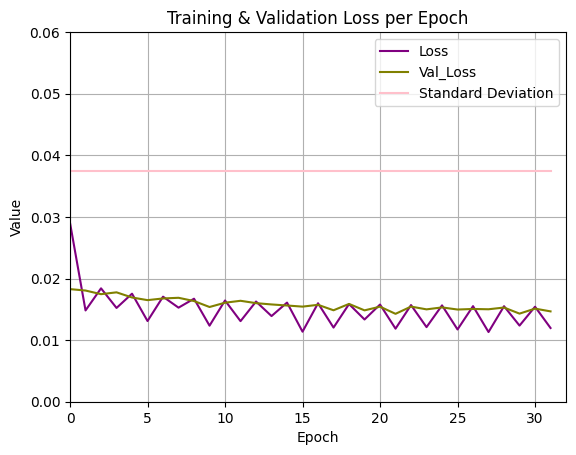

In [54]:
import matplotlib.pyplot as plt
s=[df_Scaled.std()]*32
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history.history['loss'],  color='purple',label='Loss')
plt.plot(history.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,32)

plt.legend()

plt.grid(True)
plt.savefig('val_loss_whole.png',format='png')
# Muestra el gráfico
plt.show()

In [57]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict = model.predict(test_dataset,steps=len(y_test))

   36/20706 ━━━━━━━━━━━━━━━━━━━━ 1:34 5ms/step

C:\Users\benja\AppData\Local\Temp\ipykernel_536\3065549325.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


20706/20706 ━━━━━━━━━━━━━━━━━━━━ 158s 8ms/step


In [58]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

# Calcular MAE
mae = mean_absolute_error(y_test, predict)
mse= mean_squared_error(y_test, predict)
# Calcular R-squared
r2 = r2_score(y_test, predict)
def smape(y_true, y_pred):
    """
    Calcula el Symmetric Mean Absolute Percentage Error.
    """
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-6))

smape = smape(y_test, predict)

# Imprimir las métricas
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R-squared: {r2}")
print(f"SMAPE: {smape}%")

MAE: 0.015187220733338938
MSE: 0.0006708432247534437
R-squared: 0.4793502993498998
SMAPE: 27.831136097675735%


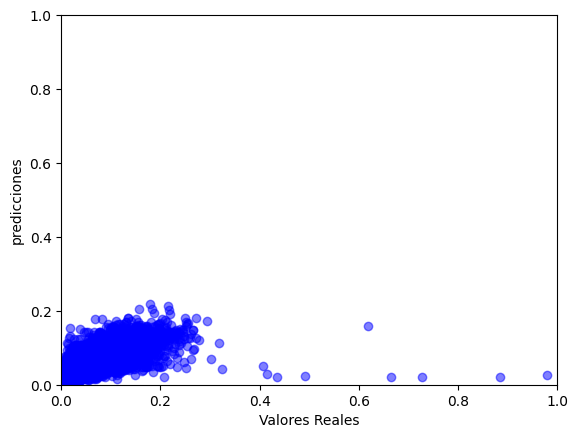

In [69]:
plt.scatter(y_test, predict, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

In [74]:
df['mp10'].describe()

count    151917.000000
mean         55.948889
std          34.322277
min           0.000000
25%          34.208300
50%          49.000000
75%          69.833300
max         917.940000
Name: mp10, dtype: float64

C:\Users\benja\AppData\Local\Temp\ipykernel_536\2569167324.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(y_test[a]))


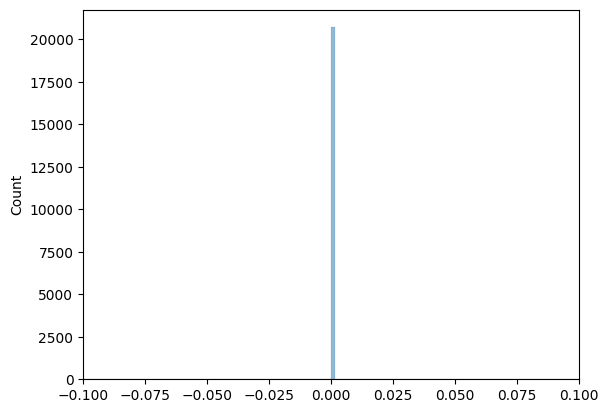

In [65]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(y_test[a]))
    import seaborn as sns
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 7 días para predecir promedio semanal siguiente (Sin capping)

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = np.mean(target[i:i+7])
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (103015, 7, 17), Forma de y: (103015, 1), Total de imágenes: (103015,)
Train set: X=(72110, 7, 17), y=(72110, 1), images=(72110,)
Test set: X=(20706, 7, 17), y=(20706, 1), images=(20706,)
Validation set: X=(10199, 7, 17), y=(10199, 1), images=(10199,)


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import LSTM, Concatenate
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dropout
import tensorflow as tf

# Definir la métrica personalizada SMAPE
def smape(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()  # Pequeño valor para evitar divisiones por cero
    denominator = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0 + epsilon
    diff = tf.abs(y_true - y_pred) / denominator
    return 100.0 * tf.reduce_mean(diff)  # Se devuelve el error en porcentaje


# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        880 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 26, 26,    │          0 │ conv2d_2[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 12, 12,    │          0 │ conv2d_3[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    589,952 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 7, 50)     │     13,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50)        │     20,200 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 178)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     22,912 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import tensorflow as tf

# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=10,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)
checkpoint_path = "training_2/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [10]:
history=model.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


Epoch 1/50


C:\Users\benja\AppData\Local\Temp\ipykernel_21048\3065549325.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 0.1878 - mean_absolute_percentage_error: 17786.3809 - mean_squared_error: 6.1066 - smape: 47.6448
Epoch 1: saving model to training_2/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 685s 303ms/step - loss: 0.1877 - mean_absolute_percentage_error: 17786.8047 - mean_squared_error: 6.1043 - smape: 47.6432 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 24842.9805 - val_mean_squared_error: 7.5098e-04 - val_smape: 42.3049
Epoch 2/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:19 62ms/step - loss: 0.0123 - mean_absolute_percentage_error: 18.4051 - mean_squared_error: 1.9358e-04 - smape: 32.5883
Epoch 2: saving model to training_2/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 53us/step - loss: 0.0123 - mean_absolute_percentage_error: 18.4051 - mean_squared_error: 1.9358e-04 - smape: 16.3014 - val_loss: 0.0161 - val_mean_absolute_percentage_error: 19.2097 - val_mean_squared_error: 5.4818e-04 - val_smape: 17.7341
Epoch 3/50


c:\Users\benja\anaconda3\envs\ee\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.0186 - mean_absolute_percentage_error: 17726.8203 - mean_squared_error: 7.9106e-04 - smape: 43.5688
Epoch 3: saving model to training_2/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 695s 309ms/step - loss: 0.0186 - mean_absolute_percentage_error: 17727.3164 - mean_squared_error: 7.9107e-04 - smape: 43.5688 - val_loss: 0.0176 - val_mean_absolute_percentage_error: 24629.8301 - val_mean_squared_error: 7.0024e-04 - val_smape: 44.3186
Epoch 4/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:09 58ms/step - loss: 0.0113 - mean_absolute_percentage_error: 17.2241 - mean_squared_error: 1.7341e-04 - smape: 34.6346
Epoch 4: saving model to training_2/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 54us/step - loss: 0.0113 - mean_absolute_percentage_error: 17.2241 - mean_squared_error: 1.7341e-04 - smape: 17.3250 - val_loss: 0.0161 - val_mean_absolute_percentage_error: 19.1212 - val_mean_squared_error: 5.1057e-04 - val_smape: 17.5887
Epoch 5/50
2253/2253

In [11]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()

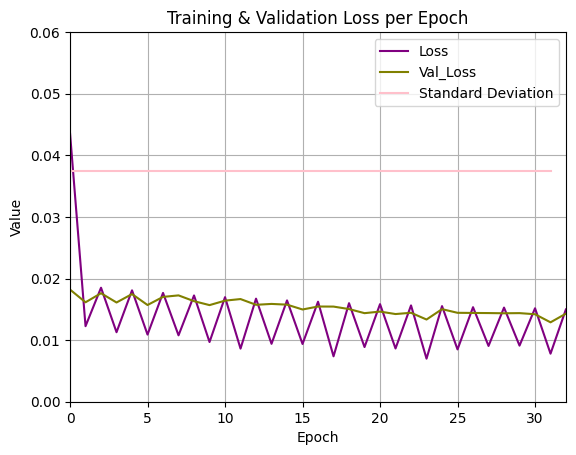

In [12]:
import matplotlib.pyplot as plt
s=[df_Scaled.std()]*32
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history.history['loss'],  color='purple',label='Loss')
plt.plot(history.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,32)

plt.legend()

plt.grid(True)
plt.savefig('val_loss_whole.png',format='png')
# Muestra el gráfico
plt.show()

In [13]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict = model.predict(test_dataset,steps=len(y_test))

C:\Users\benja\AppData\Local\Temp\ipykernel_21048\3065549325.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


20706/20706 ━━━━━━━━━━━━━━━━━━━━ 138s 7ms/step


In [14]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

# Calcular MAE
mae = mean_absolute_error(y_test, predict)
mse= mean_squared_error(y_test, predict)
# Calcular R-squared
r2 = r2_score(y_test, predict)
def smape(y_true, y_pred):
    """
    Calcula el Symmetric Mean Absolute Percentage Error.
    """
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-6))

smape = smape(y_test, predict)

# Imprimir las métricas
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R-squared: {r2}")
print(f"SMAPE: {smape}%")

MAE: 0.01453073541751304
MSE: 0.0006105665594593441
R-squared: 0.5965173125621652
SMAPE: 19.5470523928035%


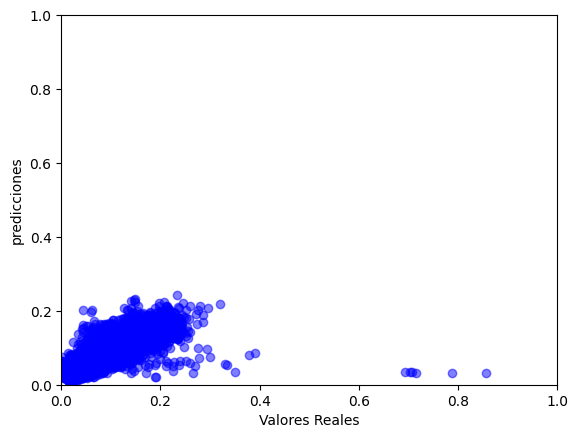

In [15]:
plt.scatter(y_test, predict, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

C:\Users\benja\AppData\Local\Temp\ipykernel_21048\2569167324.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(y_test[a]))
C:\Users\benja\AppData\Local\Temp\ipykernel_21048\2569167324.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(y_test[a]))


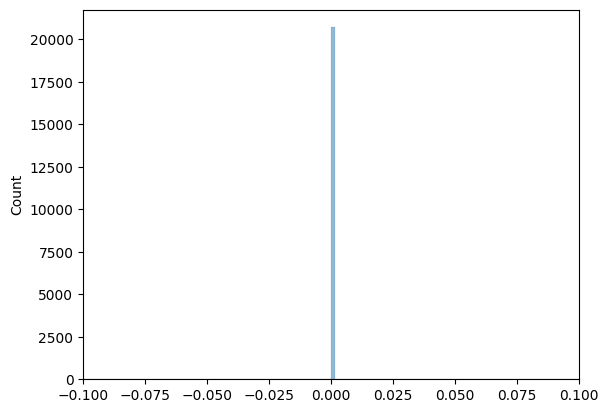

In [16]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(y_test[a]))
    import seaborn as sns
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 7 días para predecir día siguiente (Capping)

In [17]:
# Calcular la media y la desviación estándar
mean = df['mp10'].mean()
std = df['mp10'].std()

# Definir límites usando múltiplos de la desviación estándar (ej. 3 desviaciones estándar)
lower_cap = mean - 3 * std  # Límite inferior: media - 3 veces la desviación estándar
upper_cap = mean + 3 * std  # Límite superior: media + 3 veces la desviación estándar

# Aplicar el capping
df['mp10'] = df['mp10'].clip(lower=lower_cap, upper=upper_cap)

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = target[i]
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (103015, 7, 17), Forma de y: (103015, 1), Total de imágenes: (103015,)
Train set: X=(72110, 7, 17), y=(72110, 1), images=(72110,)
Test set: X=(20706, 7, 17), y=(20706, 1), images=(20706,)
Validation set: X=(10199, 7, 17), y=(10199, 1), images=(10199,)


In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import LSTM, Concatenate
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dropout
import tensorflow as tf

# Definir la métrica personalizada SMAPE
def smape(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()  # Pequeño valor para evitar divisiones por cero
    denominator = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0 + epsilon
    diff = tf.abs(y_true - y_pred) / denominator
    return 100.0 * tf.reduce_mean(diff)  # Se devuelve el error en porcentaje


# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │        880 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_4 │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_5 │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_6 │ (None, 26, 26,    │          0 │ conv2d_6[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_7 │ (None, 12, 12,    │          0 │ conv2d_7[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │    589,952 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 7, 50)     │     13,600 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 50)        │     20,200 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 178)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     22,912 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
import tensorflow as tf

# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [21]:
from tensorflow.keras.callbacks import EarlyStopping

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=10,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)


In [22]:
checkpoint_path = "training_2/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [23]:
import pickle
history=model.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)




Epoch 1/50


C:\Users\benja\AppData\Local\Temp\ipykernel_21048\3065549325.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.1387 - mean_absolute_percentage_error: 339714.2812 - mean_squared_error: 2.3545 - smape: 52.4940
Epoch 1: saving model to training_2/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 670s 296ms/step - loss: 0.1387 - mean_absolute_percentage_error: 339617.2188 - mean_squared_error: 2.3536 - smape: 52.4923 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 97878.9609 - val_mean_squared_error: 8.9195e-04 - val_smape: 48.6066
Epoch 2/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:00 54ms/step - loss: 0.0144 - mean_absolute_percentage_error: 23.8320 - mean_squared_error: 3.1865e-04 - smape: 41.5443
Epoch 2: saving model to training_2/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - loss: 0.0144 - mean_absolute_percentage_error: 23.8320 - mean_squared_error: 3.1865e-04 - smape: 20.7814 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 43.5011 - val_mean_squared_error: 6.3684e-04 - val_smape: 20.0398
Epoch 3/50


c:\Users\benja\anaconda3\envs\ee\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0186 - mean_absolute_percentage_error: 63194.9531 - mean_squared_error: 8.3579e-04 - smape: 48.5833
Epoch 3: saving model to training_2/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 664s 295ms/step - loss: 0.0186 - mean_absolute_percentage_error: 63198.5938 - mean_squared_error: 8.3578e-04 - smape: 48.5834 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 91453.2422 - val_mean_squared_error: 8.3301e-04 - val_smape: 48.4352
Epoch 4/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 1:54 51ms/step - loss: 0.0138 - mean_absolute_percentage_error: 21.8048 - mean_squared_error: 2.8800e-04 - smape: 39.8280
Epoch 4: saving model to training_2/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 55us/step - loss: 0.0138 - mean_absolute_percentage_error: 21.8048 - mean_squared_error: 2.8800e-04 - smape: 19.9228 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 37.4584 - val_mean_squared_error: 4.7958e-04 - val_smape: 19.5525
Epoch 5/50
2253/2253

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
s=[df_Scaled.std()]*32
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history.history['loss'],  color='purple',label='Loss')
plt.plot(history.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,32)

plt.legend()

plt.grid(True)
plt.savefig('val_loss_whole.png',format='png')
# Muestra el gráfico
plt.show()

In [ ]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict = model.predict(test_dataset,steps=len(y_test))

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import numpy as np

# Calcular MAE
mae = mean_absolute_error(y_test, predict)
mse= mean_squared_error(y_test, predict)
# Calcular R-squared
r2 = r2_score(y_test, predict)
def smape(y_true, y_pred):
    """
    Calcula el Symmetric Mean Absolute Percentage Error.
    """
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-6))

smape = smape(y_test, predict)

# Imprimir las métricas
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R-squared: {r2}")
print(f"SMAPE: {smape}%")

In [ ]:
plt.scatter(y_test, predict, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

In [ ]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(y_test[a]))
    import seaborn as sns
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()